# Cloudy With A Chance of Burst!☁️💥
## Naive Bayes Classifier

Import NumPy, Pandas, and Matplotlib.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

### Load the Dataset and Preprocess
Let's load in the dataset, here we are using the ['CloudBurst' dataset](https://www.kaggle.com/datasets/akshat234/cloudburst) by [Akshat_234](https://www.kaggle.com/akshat234), which in turn seems to be derived from the ['Rain in Australia' dataset](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package/data) by [Joe Young](https://www.kaggle.com/jsphyg) and [Adam Young](https://www.kaggle.com/adamyoung32). 

We remove certain unwanted columns with a lot of nulls, as well as fill the remaining columns' null values with the mean and forward fill for continous and categorical values respectively.

In [2]:
dataset = pd.read_csv('cloudpredictionsystemproject.csv')
dataset = dataset.drop(['Date', 'Evaporation', 'Sunshine', 'CloudBurstTomorrow'], axis=1)

# Filling continous column NAs with mean
numeric_columns = dataset.select_dtypes(include=np.number).columns
dataset[numeric_columns] = dataset[numeric_columns].fillna(round(dataset[numeric_columns].mean(),2))

# Filling categorical column NAs with forward fill
non_numeric_columns = dataset.select_dtypes(exclude=np.number).columns
dataset[non_numeric_columns] = dataset[non_numeric_columns].fillna(method='ffill')

dataset

,Location,MinimumTemperature,MaximumTemperature,Rainfall,WindGustDirection,WindGustSpeed,WindDirection9am,WindDirection3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temperature9am,Temperature3pm,CloudBurst Today
0,Albury,13.4,22.90,0.6,W,44.00,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.00,4.51,16.9,21.8,No
1,Albury,7.4,25.10,0.0,WNW,44.00,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,4.45,4.51,17.2,24.3,No
2,Albury,12.9,25.70,0.0,WSW,46.00,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,4.45,2.00,21.0,23.2,No
3,Albury,9.2,28.00,0.0,NE,24.00,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,4.45,4.51,18.1,26.5,No
4,Albury,17.5,32.30,1.0,W,41.00,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.00,8.00,17.8,29.7,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,Uluru,2.8,23.40,0.0,E,31.00,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,4.45,4.51,10.1,22.4,No
145456,Uluru,3.6,25.30,0.0,NNW,22.00,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,4.45,4.51,10.9,24.5,No
145457,Uluru,5.4,26.90,0.0,N,37.00,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,4.45,4.51,12.5,26.1,No
145458,Uluru,7.8,27.00,0.0,SE,28.00,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.00,2.00,15.1,26.0,No


### Examine plots of select continous values to ensure they are normally distributed
As we are implementing GaussianNB for the continous columns, it is important to ensure that these columns follow a normal distribution. We can visualise a few columns (here, minimum and maximum temperature, as well as wind gust speed) to see if it follows a central tendency.

(array([3.0570e+03, 3.8169e+04, 6.3662e+04, 2.7868e+04, 8.8460e+03,
        2.9660e+03, 6.8400e+02, 1.7300e+02, 2.7000e+01, 8.0000e+00]),
 array([  6. ,  18.9,  31.8,  44.7,  57.6,  70.5,  83.4,  96.3, 109.2,
        122.1, 135. ]),
 <BarContainer object of 10 artists>)

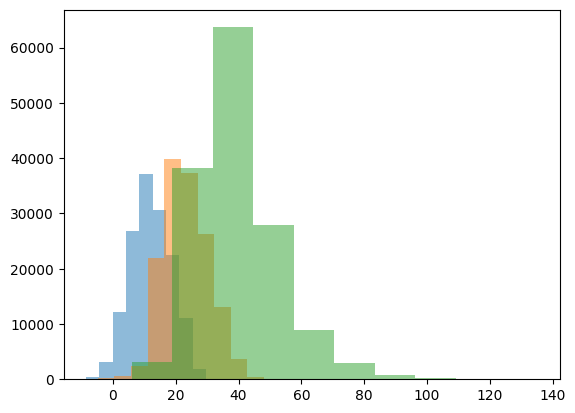

In [3]:
plt.hist(dataset['MinimumTemperature'], alpha=0.5)
plt.hist(dataset['MaximumTemperature'], alpha=0.5)
plt.hist(dataset['WindGustSpeed'], alpha=0.5)

In [4]:
#converting to numpy
dataset = dataset.to_numpy()

### Shuffle dataset and split into train and test
We shuffle the dataset and split it into train and test in a 70-30 manner.

In [5]:
np.random.shuffle(dataset)

train_size = int(0.7 * len(dataset))

train = dataset[:train_size]

test = dataset[train_size:]

train[:3], test[:3]

(array([['Mildura', 9.1, 28.0, 0.0, 'SE', 41.0, 'ESE', 'ESE', 20.0, 15.0,
         42.0, 16.0, 1019.4, 1015.3, 2.0, 4.0, 15.6, 27.0, 'No'],
        ['SalmonGums', 15.6, 34.9, 0.4, 'NE', 46.0, 'NNE', 'NNE', 19.0,
         22.0, 41.0, 13.0, 1017.65, 1015.26, 4.45, 4.51, 22.3, 33.6, 'No'],
        ['Darwin', 23.9, 33.2, 0.0, 'E', 44.0, 'ESE', 'E', 24.0, 20.0,
         48.0, 36.0, 1011.1, 1007.2, 6.0, 3.0, 27.3, 32.3, 'No']],
       dtype=object),
 array([['Brisbane', 19.8, 28.0, 0.0, 'NE', 33.0, 'ENE', 'NE', 9.0, 17.0,
         73.0, 60.0, 1015.9, 1013.5, 7.0, 2.0, 24.4, 25.8, 'No'],
        ['Watsonia', 9.7, 17.6, 0.0, 'N', 57.0, 'NNW', 'N', 15.0, 28.0,
         62.0, 48.0, 1024.3, 1019.3, 7.0, 7.0, 12.6, 17.2, 'No'],
        ['MountGambier', 19.4, 27.6, 0.0, 'S', 46.0, 'SSE', 'SSE', 24.0,
         28.0, 74.0, 55.0, 1010.0, 1010.0, 4.45, 4.51, 22.8, 26.3, 'No']],
       dtype=object))

### Calculate Prior Probabilities
Here, we calculate the probabilities of the datset yielding result yes and no. 

In [6]:
# Cloudburst
total_yes = np.sum(train[:,-1] == "Yes")
prior_yes = total_yes/len(train)

# No cloudburst
total_no = np.sum(train[:,-1] == "No")
prior_no = total_no/len(train)

total_yes, total_no, prior_yes,  prior_no

(22953, 78869, 0.2254227966451258, 0.7745772033548742)

### Memoise Frequently Queried Values
During the calculation of conditional probabilities, a lot of values are frequently recomputed. These include the means and standard deviations of each 'yes' and 'no' resultant row, as well as the conditional probabilities of unique categorical values. By implmenting memoisation, we intend to give a significant boost to inference.

In [7]:
memo_num = {}
memo_cat = []
for i in range(len(train[0]) - 1):
    feature = train[:, i]
    if not np.issubdtype(feature.dtype, np.number):
        unique, counts = np.unique(train[train[:, -1] == "Yes", i], return_counts=True)
        prob_yes = {k: v / total_yes for k, v in zip(unique, counts)}
        unique, counts = np.unique(train[train[:, -1] == "No", i], return_counts=True)
        prob_no = {k: v / total_no for k, v in zip(unique, counts)}
        memo_cat.append((prob_yes, prob_no))

### Calculate Conditional Probability
We find the probabilty of the unique values in the train dataset for results yes and no. By applying the logarithmic function over these probabilities, we ensure that future errors due to numerical underflow are prevented.

In [8]:
def gaussian(mean, std, x):
    return (1 / (np.sqrt(2 * np.pi) * std**2)) * np.exp(-0.5 * ((x - mean) / (std))**2)

def conditional_probability_np(row):
    yes = []
    no = []
    for i in range(len(row)):
        feature = train[:, i]
        if np.issubdtype(feature.dtype, np.number):
            if memo_num.get(i) is None:
                valyes = feature[train[:, -1] == "Yes"]
                valno = feature[train[:, -1] == "No"]
                memo_num[row[i]] = (np.mean(valyes), 
                           np.std(valyes, ddof=1), 
                           np.mean(valno), 
                           np.std(valno, ddof=1))
            meanyes, stdyes, meanno, stdno = memo_num[i]
            
            yes_prob = gaussian(meanyes, stdyes, row[i])
            no_prob = gaussian(meanno, stdno, row[i])
            yes.append(yes_prob)
            no.append(no_prob)
        else:
            prob_yes, prob_no = memo_cat[i]
            
            yes.append(prob_yes.get(row[i], 0))
            no.append(prob_no.get(row[i], 0))
            
    return yes, no

### Applying Bayes Theorem
By applying the logic of Naive Bayes Theorem, we find and return the probabilities of the particular attributes for both results, yes and no over the overall occurence of the result in the dataset.

In [9]:
epsilon = 1e-32
def bayes(row):
    cond_yes, cond_no = conditional_probability_np(row)
    prob_yes = np.log(np.array(cond_yes) + epsilon) + np.log(prior_yes + epsilon)
    prob_no = np.log(np.array(cond_no) + epsilon) + np.log(prior_no + epsilon) 
    return prob_yes, prob_no

### Testing
We test the model on the test dataset and check for the accuracy for both yes and no individually.

In [10]:
correctyes=0
correctno=0
for row in test: 
    prob_yes, prob_no = bayes(row[:-1])
    if np.sum(prob_yes) > np.sum(prob_no) and row[-1] == "Yes":
        correctyes+=1
    elif  np.sum(prob_yes) < np.sum(prob_no) and row[-1] == "No":
        correctno+=1

print(f'Correct Yes Accuracy: {correctyes/np.sum(test[:,-1] == "Yes")*100}%')
print(f'Correct No accuracy: {correctno/np.sum(test[:,-1] == "No")*100}%')

Correct Yes Accuracy: 95.97308594148231%
Correct No accuracy: 99.9970439563688%


### Results
Over a sample of 100 values, we have a remarkable probability of

| Correct Yes Inferences | Correct No Inferences | 
|------------------------|-----------------------|
| 95.973% | 99.997% |